# NLP Homework 2: Part of Speech (POS) Tagging 

Done by: Abdulrahman Hisham Al Muaitah  
University ID: 202110856

## Task 1: Build a Part of Speech Tagger Using Pre-DL Classifiers

#### Installing/importing libraries 

In [40]:
!pip install pyconll

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import pandas as pd 
import numpy as np
import csv 
import gensim as gs 
import multiprocessing 
from gensim.models.word2vec import Word2Vec
import pyconll
import seaborn as sns 
import matplotlib.pyplot as plt 

#### Downloading the latest version of Universal Dependencies (UD 2.10) and loading the Arabic related UDs to the Google Colab runtime environment from Google Drive for faster loading 

In [ ]:
!wget https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-4758/allzip
!unzip /content/allzip -d /content/files
!tar zxvf /content/files/ud-treebanks-v2.10.tgz
!mv /content/ud-treebanks-v2.10/UD_Arabic-NYUAD /content/UD_Arabic-NYUAD
!mv /content/ud-treebanks-v2.10/UD_Arabic-PADT /content/UD_Arabic-PADT
!mv /content/ud-treebanks-v2.10/UD_Arabic-PUD /content/UD_Arabic-PUD

#### Loading the ConLL-U files for the PADT and PUD Arabic Universal Dependencies 
Notes:  
1. PADT contains a test set and a train set, I'm going to merge them in the later preprocessing steps, shuffle them, and split them, before feeding them to the Pre-DL and DL Models, a specific random seed will be selected to ensure reproducibility. 
2. The PUD UD only contains a small test set according to the documentation. I'm going to assume as if it's a full dataset, perform train/test split on it, and test it in Pre-DL and DL models, a specific random seed will be selected to ensure reproducibility. 

In [42]:
train_PADT = pyconll.load_from_file('/content/UD_Arabic-PADT/ar_padt-ud-train.conllu')
test_PADT = pyconll.load_from_file('/content/UD_Arabic-PADT/ar_padt-ud-test.conllu')
test_PUD = pyconll.load_from_file('/content/UD_Arabic-PUD/ar_pud-ud-test.conllu')

**We will start with the PADT dataset** 

The following algorithm I wrote, will go through each list of PyConll objects, fetch the "form" and "upos" of each word in each sentence. The "form" is the word, and "upos" is the tag.  
The algorithm will output 4 list of lists, each containing a sentence lists of the words and their corresponding tags. 

In [ ]:
wordTokenList = [] 
posTokenList = [] 
testwordTokenList = [] 
testposTokenList = [] 

trainsentences = [ i for i in train_PADT] 
for i in range(len(trainsentences) - 1): 
  sentenceList = [] 
  for j in trainsentences[i]: 
    if j.upos == None: 
      continue 
    sentenceList.append(j.form)
  wordTokenList.append(sentenceList)
print("The word sentence list: \n",wordTokenList[:500])

for i in range(len(trainsentences) - 1): 
  sentenceList = [] 
  for j in trainsentences[i]: 
    if j.upos == None: 
      continue 
    sentenceList.append(j.upos)
  posTokenList.append(sentenceList)
print("The POS sentence list: \n",posTokenList[:500])

testsentences = [ i for i in test_PADT] 
for i in range(len(testsentences) - 1): 
  sentenceList = [] 
  for j in testsentences[i]: 
    if j.upos == None: 
      continue 
    sentenceList.append(j.form)
  testwordTokenList.append(sentenceList)
print("The word sentence list: \n",testwordTokenList[:500])

for i in range(len(testsentences) - 1): 
  sentenceList = [] 
  for j in testsentences[i]: 
    if j.upos == None: 
      continue 
    sentenceList.append(j.upos)
  testposTokenList.append(sentenceList)
print("The POS sentence list: \n",testposTokenList[:500])

Concatenating the train and test lists for both the words and the pos tags 

In [44]:
fullWordList = wordTokenList + testwordTokenList 
fullposList = posTokenList + testposTokenList

#set() for distinguishing the unique words 
wordlen = len(set([word.lower() for sentence in fullWordList for word in sentence]))
taglen = len(set([word.lower() for sentence in fullposList for word in sentence]))

In [45]:
print("The length of the word list: ",len(fullWordList)) 
print("The length of the POS list: ",len(fullposList))
print("The number of words in the corpus: ",wordlen) 
print("The number of pos in the corpus: ",taglen)

The length of the word list:  6753
The length of the POS list:  6753
The number of words in the corpus:  23353
The number of pos in the corpus:  17


Encoding the word and pos lists to numerical representations

In [46]:
from keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer()                      
word_tokenizer.fit_on_texts(fullWordList)                  
X_encoded = word_tokenizer.texts_to_sequences(fullWordList) 
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(fullposList)
Y_encoded = tag_tokenizer.texts_to_sequences(fullposList)

There's only one thing left before we're able to feed this to a machine learning algorithm, and that is to make sure that the length of each sentence is the same, for that we will using padding, to ensure that all the sentences are of the same size.  
To showcase this problem, here's an example 

In [47]:
print("Length of the first sentence: ",len(X_encoded[0])) 
print("Length of the second sentence: ",len(X_encoded[1])) 

Length of the first sentence:  13
Length of the second sentence:  58


In [48]:
from keras_preprocessing.sequence import pad_sequences
#Assuming I want to normalize all the sentences to a length of 250 
X_pad = pad_sequences(X_encoded, maxlen=250, padding="post", truncating="post")
Y_pad = pad_sequences(Y_encoded, maxlen=250, padding="post", truncating="post")
X, Y = X_pad, Y_pad

In [49]:
print("Length of the first sentence: ",len(X_pad[0])) 
print("Length of the second sentence: ",len(X_pad[1])) 

Length of the first sentence:  250
Length of the second sentence:  250


Using Word2Vec to create word embeddings for our dataset

In [50]:
print("The number of available processor cores: ",multiprocessing.cpu_count())
w2vecModel = Word2Vec(sentences=wordTokenList+testwordTokenList,sg=1, workers=4, min_count=0)
words = list(w2vecModel.wv.vocab) 
print(len(words))

The number of available processor cores:  40
23353


In [51]:
#Example of a word in the corpus, each word is representing by a 100-value word vector, this is going to act as the embedding size of the NNs  
w2vecModel.wv['ابن']

array([ 0.2578828 ,  0.16792879, -0.263245  ,  0.261568  ,  0.02465793,
        0.12854625, -0.08625748,  0.25467253,  0.08827204, -0.01445744,
       -0.09183499, -0.06494728,  0.16214938, -0.01467899,  0.39157727,
        0.2346682 ,  0.13089636, -0.11464662,  0.21057245,  0.20380987,
        0.07002548,  0.11226785, -0.23309988, -0.14559561,  0.19215676,
       -0.05165242,  0.36131522, -0.21638964, -0.09396302, -0.12310661,
        0.08169981, -0.1661488 , -0.20502694,  0.1256887 , -0.08976509,
        0.39048535,  0.17047276, -0.05979098,  0.16668755, -0.0971319 ,
       -0.22564761, -0.08671977, -0.08546357, -0.02614637, -0.06714098,
        0.04868634,  0.02365717, -0.14170165,  0.3609997 ,  0.05820678,
       -0.02868301,  0.17300908,  0.00685653,  0.37187243, -0.10871824,
        0.06136809, -0.12023824,  0.05969888,  0.14317459,  0.08497866,
       -0.14376469,  0.0929645 ,  0.21590164, -0.26365814,  0.26032197,
        0.21705967,  0.33780876,  0.13056782,  0.09063931,  0.18

In [52]:
EMBEDDING_SIZE  = 100
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = w2vecModel[word]
    except KeyError:
        pass
print("Embeddings shape: {}".format(embedding_weights.shape))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Embeddings shape: (23354, 100)


In [53]:
#Applying one-hot encoding for the output Y
from keras.utils import to_categorical
Y = to_categorical(Y)

In [54]:
Y.shape

(6753, 250, 18)

The number of classes is 18 (noun, adj, adv,...) 

Splitting the data to train/test splits  
80/20 ratio 

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=15)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.20, random_state=15)

1. Creating a simple RNN model 

In [56]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN
model = Sequential() 
model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  100,          
                        input_length  =  250,          
                        trainable     =  True                    
))
#100 neurons
model.add(SimpleRNN(100,return_sequences=True))
model.add(TimeDistributed(Dense(18, activation='softmax')))
model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 100)          2335400   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 250, 100)          20100     
                                                                 
 time_distributed_5 (TimeDis  (None, 250, 18)          1818      
 tributed)                                                       
                                                                 
Total params: 2,357,318
Trainable params: 2,357,318
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_training = model.fit(X_train, Y_train, batch_size=250, epochs=25, validation_data=(X_validation, Y_validation))

Epoch 1/25
18/18 [==============================] - 9s 395ms/step - loss: 1.3134 - acc: 0.7987 - val_loss: 0.7941 - val_acc: 0.8434
Epoch 2/25
18/18 [==============================] - 7s 378ms/step - loss: 1.4354 - acc: 0.7669 - val_loss: 0.5865 - val_acc: 0.8533
Epoch 3/25
18/18 [==============================] - 7s 390ms/step - loss: 0.5425 - acc: 0.8587 - val_loss: 0.4741 - val_acc: 0.8733
Epoch 4/25
18/18 [==============================] - 7s 389ms/step - loss: 0.4405 - acc: 0.8895 - val_loss: 0.4158 - val_acc: 0.9043
Epoch 5/25
18/18 [==============================] - 7s 367ms/step - loss: 0.3821 - acc: 0.9099 - val_loss: 0.3678 - val_acc: 0.9041
Epoch 6/25
18/18 [==============================] - 6s 361ms/step - loss: 0.3429 - acc: 0.9061 - val_loss: 0.3383 - val_acc: 0.9043
Epoch 7/25
18/18 [==============================] - 7s 363ms/step - loss: 0.3169 - acc: 0.9120 - val_loss: 0.3178 - val_acc: 0.9136
Epoch 8/25
18/18 [==============================] - 7s 361ms/step - loss: 0.

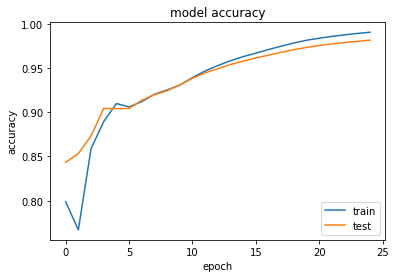

In [59]:
plt.plot(model_training.history['acc'])
plt.plot(model_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

2. Creating a multi-layer RNN model

In [60]:
model2 = Sequential() 
model2.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  100,          
                        input_length  =  250,          
                        trainable     =  True                    
))
#100 neurons
model2.add(SimpleRNN(100,return_sequences=True))
model2.add(SimpleRNN(100,return_sequences=True))
model2.add(TimeDistributed(Dense(18, activation='softmax')))
model2.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [61]:
model2.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 100)          2335400   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 250, 100)          20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 250, 100)          20100     
                                                                 
 time_distributed_6 (TimeDis  (None, 250, 18)          1818      
 tributed)                                                       
                                                                 
Total params: 2,377,418
Trainable params: 2,377,418
Non-trainable params: 0
_________________________________________________________________


In [62]:
model2_training = model2.fit(X_train, Y_train, batch_size=250, epochs=25, validation_data=(X_validation, Y_validation))

Epoch 1/25
18/18 [==============================] - 13s 622ms/step - loss: 1.0140 - acc: 0.7539 - val_loss: 0.4842 - val_acc: 0.8565
Epoch 2/25
18/18 [==============================] - 11s 615ms/step - loss: 0.4238 - acc: 0.8813 - val_loss: 0.3986 - val_acc: 0.8895
Epoch 3/25
18/18 [==============================] - 11s 609ms/step - loss: 0.3558 - acc: 0.8976 - val_loss: 0.3630 - val_acc: 0.8933
Epoch 4/25
18/18 [==============================] - 11s 590ms/step - loss: 0.3283 - acc: 0.9008 - val_loss: 0.3522 - val_acc: 0.8943
Epoch 5/25
18/18 [==============================] - 11s 599ms/step - loss: 0.3120 - acc: 0.9039 - val_loss: 0.3430 - val_acc: 0.8985
Epoch 6/25
18/18 [==============================] - 11s 595ms/step - loss: 0.2974 - acc: 0.9099 - val_loss: 0.3310 - val_acc: 0.9025
Epoch 7/25
18/18 [==============================] - 10s 576ms/step - loss: 0.2811 - acc: 0.9181 - val_loss: 0.3167 - val_acc: 0.9105
Epoch 8/25
18/18 [==============================] - 10s 584ms/step - 

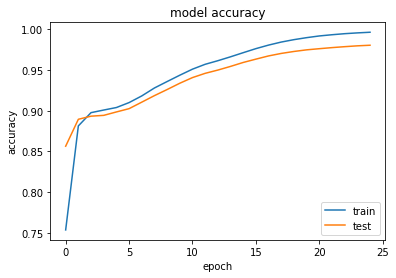

In [63]:
plt.plot(model2_training.history['acc'])
plt.plot(model2_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

3. Creating an LSTM RNN Model 

In [64]:
model3 = Sequential() 
model3.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  100,          
                        input_length  =  250,          
                        trainable     =  True                    
))
#100 neurons
model3.add(LSTM(100,return_sequences=True))
model3.add(TimeDistributed(Dense(18, activation='softmax')))
model3.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [65]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 250, 100)          2335400   
                                                                 
 lstm_3 (LSTM)               (None, 250, 100)          80400     
                                                                 
 time_distributed_7 (TimeDis  (None, 250, 18)          1818      
 tributed)                                                       
                                                                 
Total params: 2,417,618
Trainable params: 2,417,618
Non-trainable params: 0
_________________________________________________________________


In [66]:
model3_training = model3.fit(X_train, Y_train, batch_size=250, epochs=25, validation_data=(X_validation, Y_validation))

Epoch 1/25
18/18 [==============================] - 17s 824ms/step - loss: 1.7084 - acc: 0.8029 - val_loss: 0.7003 - val_acc: 0.8491
Epoch 2/25
18/18 [==============================] - 14s 783ms/step - loss: 0.5670 - acc: 0.8555 - val_loss: 0.4983 - val_acc: 0.8571
Epoch 3/25
18/18 [==============================] - 14s 795ms/step - loss: 0.4642 - acc: 0.8801 - val_loss: 0.4574 - val_acc: 0.8904
Epoch 4/25
18/18 [==============================] - 14s 801ms/step - loss: 0.4429 - acc: 0.8912 - val_loss: 0.4462 - val_acc: 0.8897
Epoch 5/25
18/18 [==============================] - 14s 795ms/step - loss: 0.4328 - acc: 0.8900 - val_loss: 0.4403 - val_acc: 0.8891
Epoch 6/25
18/18 [==============================] - 14s 793ms/step - loss: 0.4236 - acc: 0.8915 - val_loss: 0.4273 - val_acc: 0.8945
Epoch 7/25
18/18 [==============================] - 14s 803ms/step - loss: 0.4106 - acc: 0.8982 - val_loss: 0.4046 - val_acc: 0.8979
Epoch 8/25
18/18 [==============================] - 14s 793ms/step - 

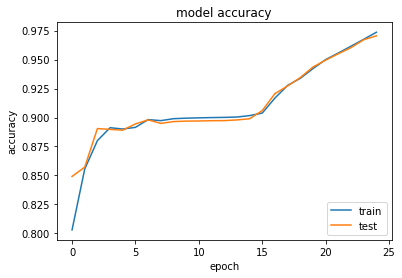

In [67]:
plt.plot(model3_training.history['acc'])
plt.plot(model3_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

4. Creating a multi-layer LSTM RNN model 

In [68]:
model4 = Sequential() 
model4.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  100,          
                        input_length  =  250,          
                        trainable     =  True                    
))
#100 neurons
model4.add(LSTM(100,return_sequences=True))
model4.add(LSTM(100,return_sequences=True))
model4.add(TimeDistributed(Dense(18, activation='softmax')))
model4.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [69]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 250, 100)          2335400   
                                                                 
 lstm_4 (LSTM)               (None, 250, 100)          80400     
                                                                 
 lstm_5 (LSTM)               (None, 250, 100)          80400     
                                                                 
 time_distributed_8 (TimeDis  (None, 250, 18)          1818      
 tributed)                                                       
                                                                 
Total params: 2,498,018
Trainable params: 2,498,018
Non-trainable params: 0
_________________________________________________________________


In [70]:
model4_training = model4.fit(X_train, Y_train, batch_size=250, epochs=25, validation_data=(X_validation, Y_validation))

Epoch 1/25
18/18 [==============================] - 34s 2s/step - loss: 1.4793 - acc: 0.8026 - val_loss: 0.7168 - val_acc: 0.8490
Epoch 2/25
18/18 [==============================] - 28s 2s/step - loss: 0.5576 - acc: 0.8473 - val_loss: 0.5016 - val_acc: 0.8531
Epoch 3/25
18/18 [==============================] - 28s 2s/step - loss: 0.4566 - acc: 0.8608 - val_loss: 0.4457 - val_acc: 0.8550
Epoch 4/25
18/18 [==============================] - 28s 2s/step - loss: 0.4226 - acc: 0.8591 - val_loss: 0.4081 - val_acc: 0.8760
Epoch 5/25
18/18 [==============================] - 28s 2s/step - loss: 0.3860 - acc: 0.8850 - val_loss: 0.3798 - val_acc: 0.8872
Epoch 6/25
18/18 [==============================] - 29s 2s/step - loss: 0.3633 - acc: 0.8922 - val_loss: 0.3670 - val_acc: 0.8903
Epoch 7/25
18/18 [==============================] - 28s 2s/step - loss: 0.3517 - acc: 0.8954 - val_loss: 0.3570 - val_acc: 0.8936
Epoch 8/25
18/18 [==============================] - 28s 2s/step - loss: 0.3419 - acc: 0.89

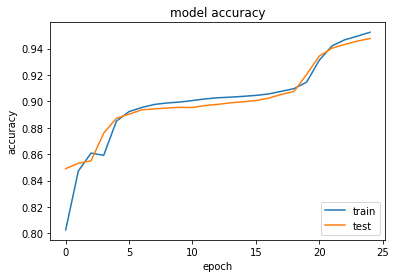

In [71]:
plt.plot(model4_training.history['acc'])
plt.plot(model4_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

5. Creating a GRU RNN model

In [72]:
model5 = Sequential() 
model5.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  100,          
                        input_length  =  250,          
                        trainable     =  True                    
))
#100 neurons
model5.add(GRU(100,return_sequences=True))
model5.add(TimeDistributed(Dense(18, activation='softmax')))
model5.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [73]:
model5.summary() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 250, 100)          2335400   
                                                                 
 gru_1 (GRU)                 (None, 250, 100)          60600     
                                                                 
 time_distributed_9 (TimeDis  (None, 250, 18)          1818      
 tributed)                                                       
                                                                 
Total params: 2,397,818
Trainable params: 2,397,818
Non-trainable params: 0
_________________________________________________________________


In [74]:
model5_training = model5.fit(X_train, Y_train, batch_size=250, epochs=25, validation_data=(X_validation, Y_validation))

Epoch 1/25
18/18 [==============================] - 15s 712ms/step - loss: 2.0975 - acc: 0.8023 - val_loss: 0.4732 - val_acc: 0.8490
Epoch 2/25
18/18 [==============================] - 12s 678ms/step - loss: 0.4933 - acc: 0.8553 - val_loss: 0.4481 - val_acc: 0.8853
Epoch 3/25
18/18 [==============================] - 12s 696ms/step - loss: 0.4377 - acc: 0.9082 - val_loss: 0.4343 - val_acc: 0.9041
Epoch 4/25
18/18 [==============================] - 12s 682ms/step - loss: 0.4197 - acc: 0.8989 - val_loss: 0.4182 - val_acc: 0.8805
Epoch 5/25
18/18 [==============================] - 12s 684ms/step - loss: 0.4051 - acc: 0.8811 - val_loss: 0.4043 - val_acc: 0.8752
Epoch 6/25
18/18 [==============================] - 12s 691ms/step - loss: 0.3883 - acc: 0.8859 - val_loss: 0.3832 - val_acc: 0.8895
Epoch 7/25
18/18 [==============================] - 12s 680ms/step - loss: 0.3616 - acc: 0.8980 - val_loss: 0.3489 - val_acc: 0.8987
Epoch 8/25
18/18 [==============================] - 12s 678ms/step - 

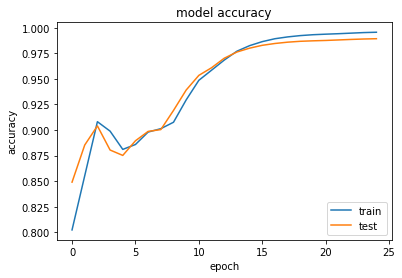

In [75]:
plt.plot(model5_training.history['acc'])
plt.plot(model5_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

We can see that the performance of the different architectures (SimpleRNN, Multi-Layer SimpleRNN, LSTM, Multi-Layer LSTM, and GRU) give adequate results in terms of model accuracy and loss. SimpleRNN and GRU showed the best accuracy results of 98% 

Evaluating some of the NN models with a sample sentence: 
1. SimpleRNN Model

In [80]:
sentence = 'ذهب بوتين الى سوريا العام الماضي'
sentencelist = sentence.split() 
seq =[word_tokenizer.texts_to_sequences(sentencelist)]
pad_seq = pad_sequences(seq, maxlen=250, padding='post', truncating='post')
#print(pad_seq)
pad_seq = np.squeeze(pad_seq,axis=-1)
pred = np.squeeze(model.predict(pad_seq).argmax(-1))
#print(pred)
output = [tag_tokenizer.index_word[tag] for tag in pred if tag != 0]
#print(output)
word_tag = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
print(word_tag) 

1/1 [==============================] - 0s 32ms/step
[('ذهب', 'verb'), ('بوتين', 'x'), ('الى', 'adp'), ('سوريا', 'x'), ('العام', 'noun'), ('الماضي', 'adj')]


2. GRU Model 

In [81]:
sentence = 'ذهب بوتين الى سوريا العام الماضي'
sentencelist = sentence.split() 
seq =[word_tokenizer.texts_to_sequences(sentencelist)]
pad_seq = pad_sequences(seq, maxlen=250, padding='post', truncating='post')
#print(pad_seq)
pad_seq = np.squeeze(pad_seq,axis=-1)
pred = np.squeeze(model5.predict(pad_seq).argmax(-1))
#print(pred)
output = [tag_tokenizer.index_word[tag] for tag in pred if tag != 0]
#print(output)
word_tag = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
print(word_tag) 

1/1 [==============================] - 0s 40ms/step
[('ذهب', 'verb'), ('بوتين', 'x'), ('الى', 'adp'), ('سوريا', 'x'), ('العام', 'adj'), ('الماضي', 'adj')]


In [83]:
sentence = 'بوتين ذهب الى المانيا في القارة الاوروبية'
sentenceList = sentence.split(" ")
#print(sentenceList)
encoded_sentence = [word_tokenizer.texts_to_sequences(sentenceList)] 
#print(encoded_sentence)
test_pad = pad_sequences(encoded_sentence,maxlen=250,padding="post",truncating="post")
test_pad = np.squeeze(test_pad,axis=-1)
pred = np.squeeze(model5.predict(test_pad).argmax(-1)) 
output = [tag_tokenizer.index_word[tag] for tag in pred if tag != 0]
#print(output)
word_tag = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
print(word_tag) 

1/1 [==============================] - 0s 36ms/step
[('بوتين', 'x'), ('ذهب', 'verb'), ('الى', 'adp'), ('المانيا', 'x'), ('في', 'adp'), ('القارة', 'noun'), ('الاوروبية', 'adj')]


#### Pre-DL Classifiers 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.svm import SVC 
from sklearn import preprocessing 

In [ ]:
words =fullWordList 
tags = [word.lower() for sentence in fullposList for word in sentence]
print(len(words)) 
print(len(tags)) 
print(tags[:20])

6753
252085
['x', 'verb', 'noun', 'noun', 'adj', 'adp', 'noun', 'noun', 'noun', 'punct', 'x', 'punct', 'adj', 'x', 'num', 'punct', 'num', 'punct', 'x', 'x']


In [ ]:
svmW2V = Word2Vec(sentences=fullWordList,size=100,workers=4,window=1,min_count=0) 

In [ ]:
X = [] 
for i in range(len(words)): 
  wvlist = [] 
  for k in range(len(words[i])): 
    wvlist.append(svmW2V.wv[words[i][k]]) 
  X.append(wvlist) 
print(len(X))

X = [item for sublist in X for item in sublist] 
print(len(X))

6753
252085


In [ ]:
le = preprocessing.LabelEncoder() 
y = le.fit_transform(tags)

In [ ]:
y

array([16, 15,  7, ..., 16,  7, 12])

In [ ]:
print(len(X[0]))
print(len(X[1]))


100
100


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=15)

In [ ]:
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

(201668, 100) (201668,)
(50417, 100) (50417,)


In [ ]:
clf = SVC()

In [ ]:
clf.fit(X_train, y_train) 

SVC()

Training the SVM classifier took about 2 hours 

In [ ]:
y_pred = clf.predict(X_test)

Using the SVM classifier to make predictions took about 15 mins 

In [ ]:
pred_labels = le.inverse_transform(y_pred)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Accuracy = {0:.2f}".format(accuracy))
print("Precision = {0:.2f}".format(precision))
print("Recall = {0:.2f}".format(recall))

Accuracy = 0.73
Precision = 0.81
Recall = 0.73


In [ ]:
textInput = 'بوتين ذهب الى المانيا في القارة الاوروبية'
tokens = textInput.split() 

In [ ]:
test_data = []
for i in range(len(tokens)):
    test_data.append(svmW2V.wv[tokens[i]])

In [ ]:
y_pred = clf.predict(test_data)
y_pred

array([7, 7, 1, 7, 1, 7, 7])

In [ ]:
le.inverse_transform(y_pred)

array(['noun', 'noun', 'adp', 'noun', 'adp', 'noun', 'noun'], dtype='<U5')

As seen in the SVM Model, it is not able to differentiate between the nouns and the names very well, it treated the name "بوتين" at the beginning of the sentence as a noun where it should have been treated as a name. The SVM model is not able to capture the relationships of words and word meanings and how they are used in different sentences. I believe the issue is that we're feeding the SVM model a word by word input, hence why it is not able to determine the relationships on a sentence by sentence basis. 